## Exploratory Data Analysis ##
Although the Kaggle competition uses Auc to measure success in this project we decided to concentrate on Sensitivity as we want to identify as much of the West Nile virus as possible.  We will not be able to judge our sensitivity score on the test data as it will evaluate us on Auc but we will still treat the test data as though we are evaluating it by Sensitivity

In [1]:
# Installed geopy, which is a tool to help determine distances between objects.  We used this below to determine
# the distance between if West Nile Virus is presenet to those cases it wasn't, by year
!pip install geopy

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import time

In [4]:
# Import csv data files and assign to variable
spray = pd.read_csv('./data/spray.csv')
weather = pd.read_csv('./data/weather.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [5]:
# Use the imported column names and lowercase all letters and add an underscore where spaces exist between words
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]
spray.columns = [col.lower().replace(' ', '_') for col in spray.columns]
weather.columns = [col.lower().replace(' ', '_') for col in weather.columns]

In [6]:
#create baseline file to upload to Kaggle
baseline=test.loc[:,("id")]
baseline['wnvpresent'] = 0
baseline.to_csv('../Data/baselinesubmission.csv', index=False)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


FileNotFoundError: [Errno 2] No such file or directory: '../Data/baselinesubmission.csv'

#### Baseline Score

We created a baseline file, where there were no West Nile Virus predictions made (all zero's), to upload to Kaggle to get an idea what the score would be, according to their measurements.  Our score was .5 which is the baseline of AUC when the model does not distiquish classes at all.

In [7]:
#Look at the propotion of cases without West Nile 94.7%
1-train['wnvpresent'].mean()

0.9475537787930707

#### Unbalance Classes

There are many more cases of the negative class than the positive class.  This can cause problems with identifying the smaller class. 
We may want to look into oversampling the train data for West Nile Present cases to help predict the positive class.

In [8]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
date         14835 non-null object
time         14251 non-null object
latitude     14835 non-null float64
longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [9]:
#looked for null values in spray dataset
spray[spray.isnull().any(axis=1)]

,date,time,latitude,longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
1035,2011-09-07,NaN,41.986372,-87.794862
1036,2011-09-07,NaN,41.986228,-87.795582
1037,2011-09-07,NaN,41.984836,-87.793998
1038,2011-09-07,NaN,41.984836,-87.794670
1039,2011-09-07,NaN,41.984884,-87.795198


In [10]:
# Dropped time column from spray because it isn't contained in any other datasets, and has a high number of missing
# values
spray.drop(columns='time', inplace=True)

## Visuals of Train Dataset

Much of the data does not seem to be normally distributed and there are many large unordered categorical classes.  This leads us to conclude that we may want to try a decision tree model.

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlu

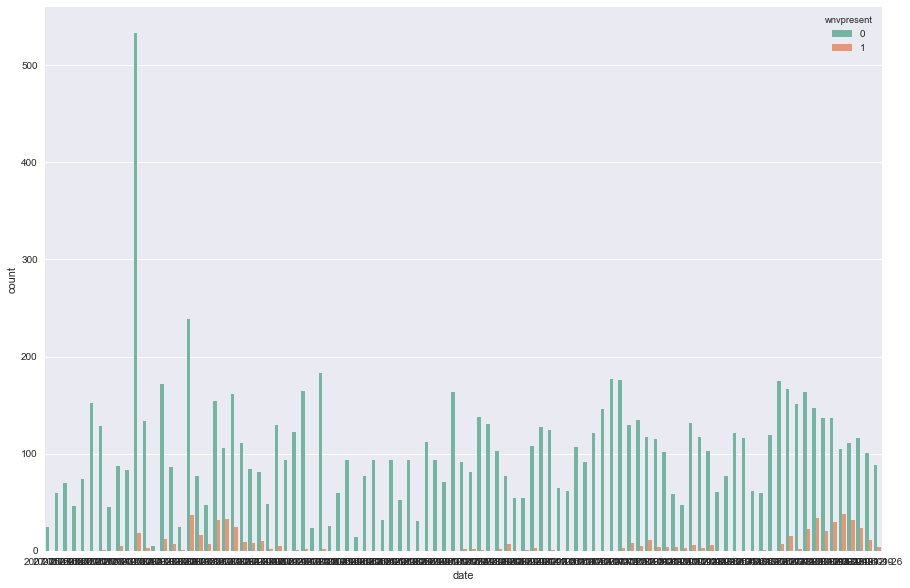

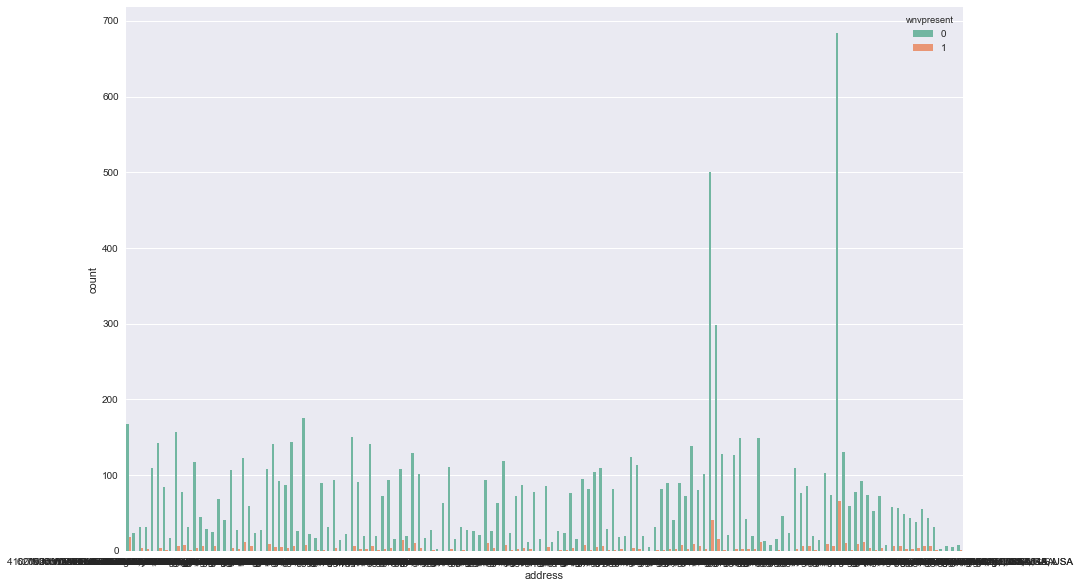

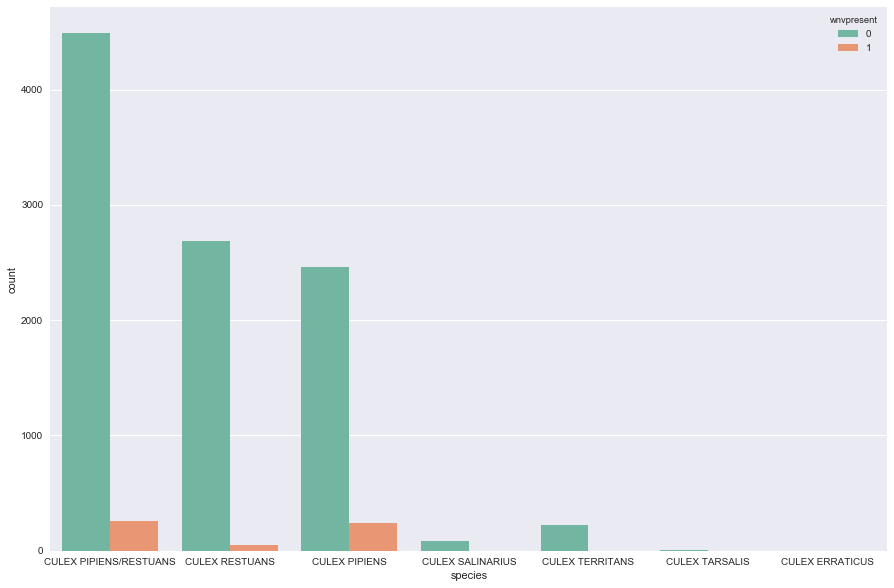

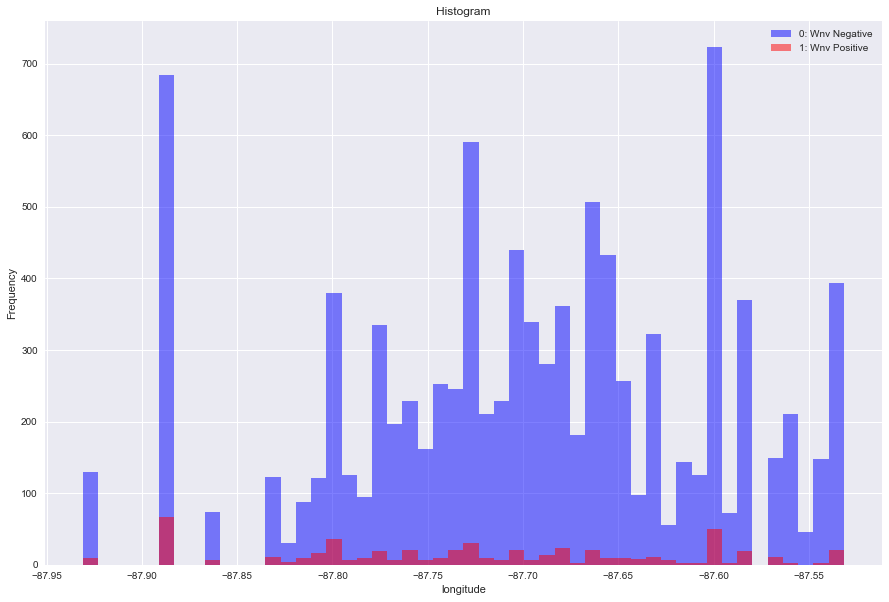

<Figure size 1080x720 with 0 Axes>

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 1080x720 with 0 Axes>

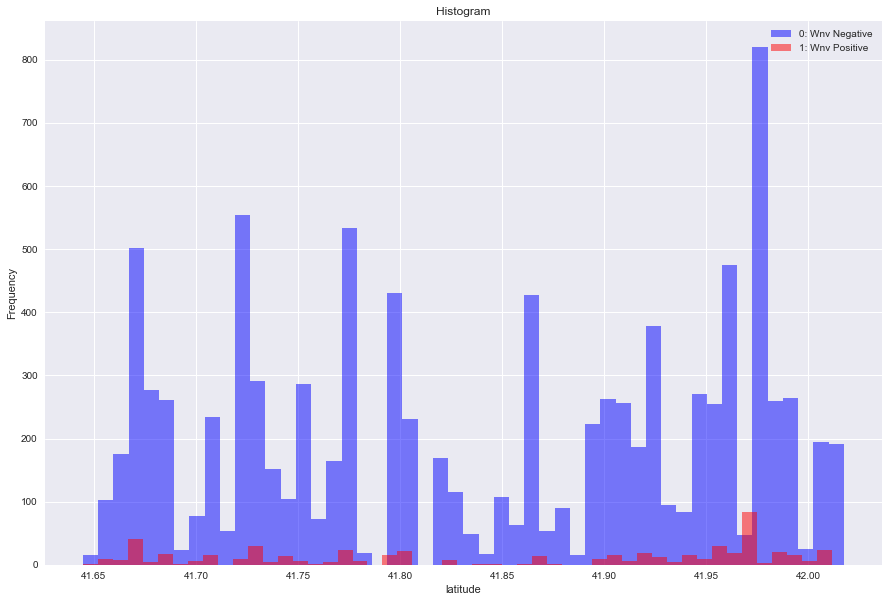

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 1080x720 with 0 Axes>

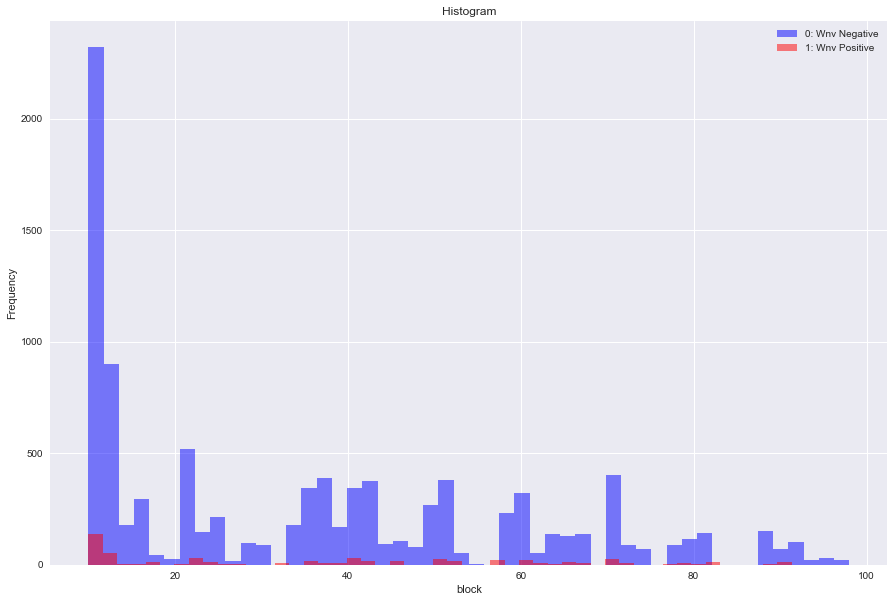

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 1080x720 with 0 Axes>

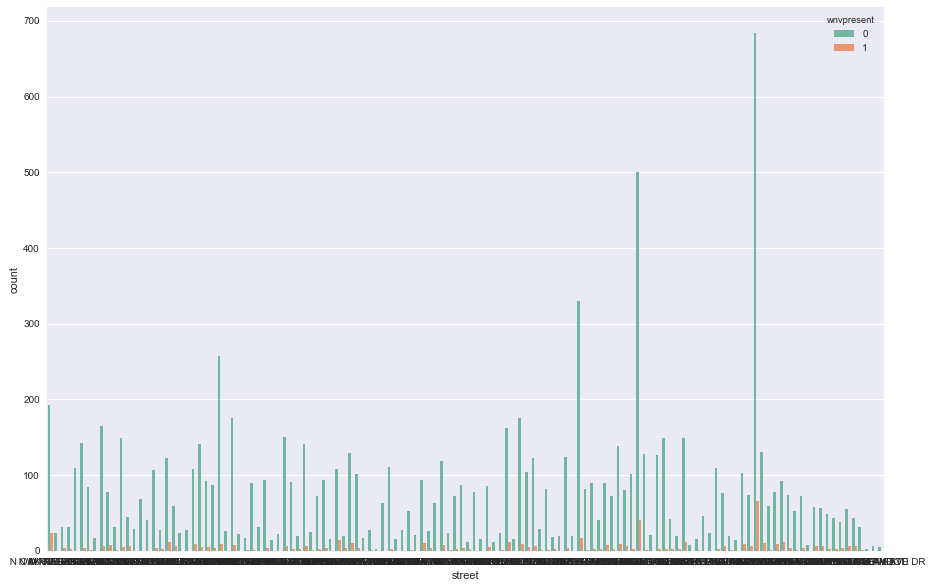

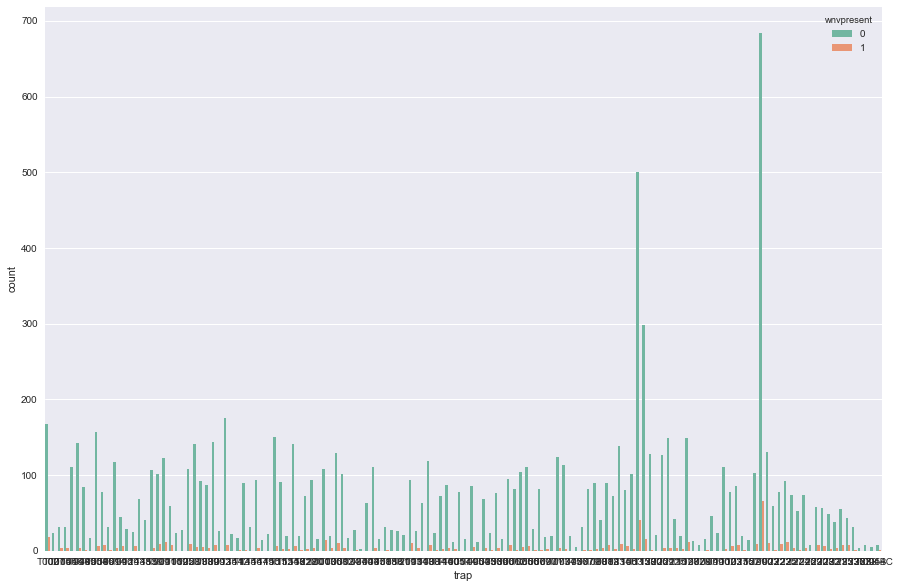

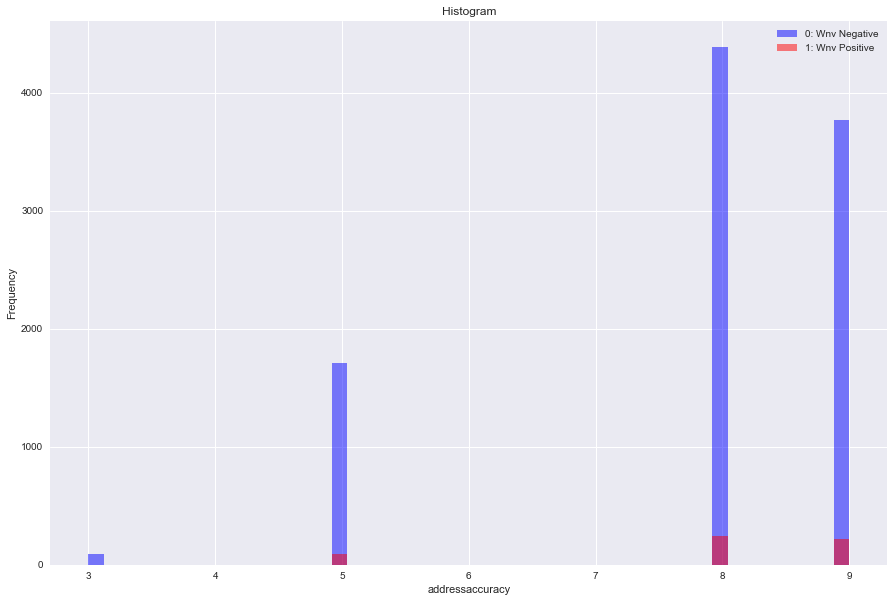

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 1080x720 with 0 Axes>

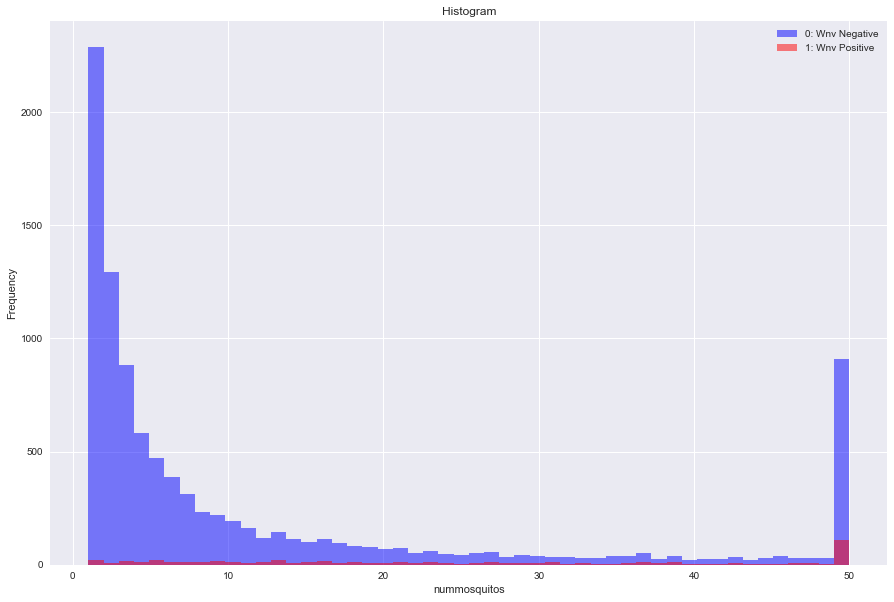

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 1080x720 with 0 Axes>

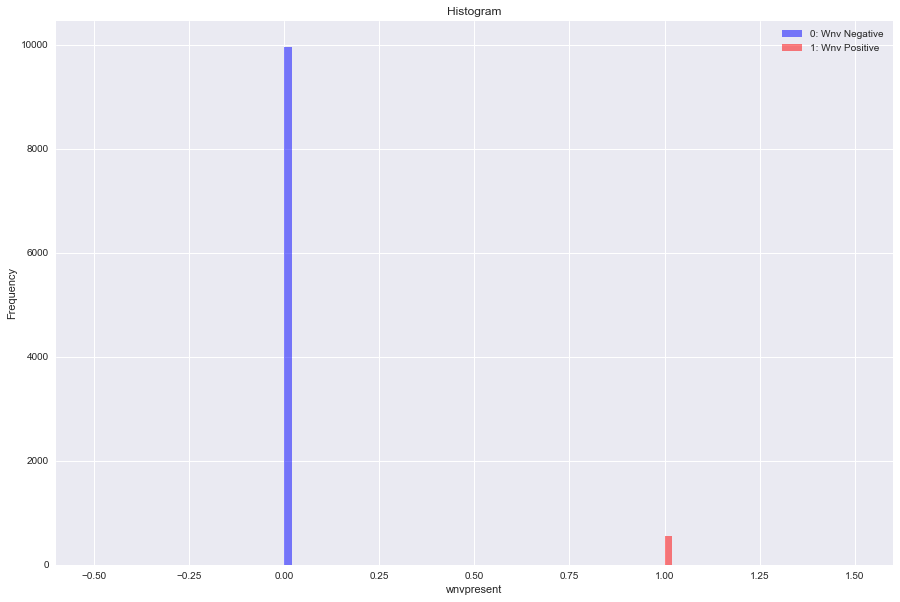

In [11]:
# Various graphs based on if WNV is present or not compared to other columns in train dataset


# columns for visuals
col_use=train[['address','date','species','longitude','latitude','block','street','trap',
               'addressaccuracy','nummosquitos','wnvpresent']]


for i, col in enumerate(col_use.columns):
    try:
        sns.set(rc={'figure.figsize':(15,10)})
        plt.figure(figsize=(15,10))
        plt.figure(i)
        var1 = col_use[col_use['wnvpresent'] == 1][col]
        var2 = col_use[col_use['wnvpresent'] != 1][col]
        plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
        plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
        plt.title("Histogram")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show();
    except:
        sns.set(rc={'figure.figsize':(15,10)})
        plt.figure(i)
        sns.countplot(x=col, hue="wnvpresent", data=col_use, palette="Set2");

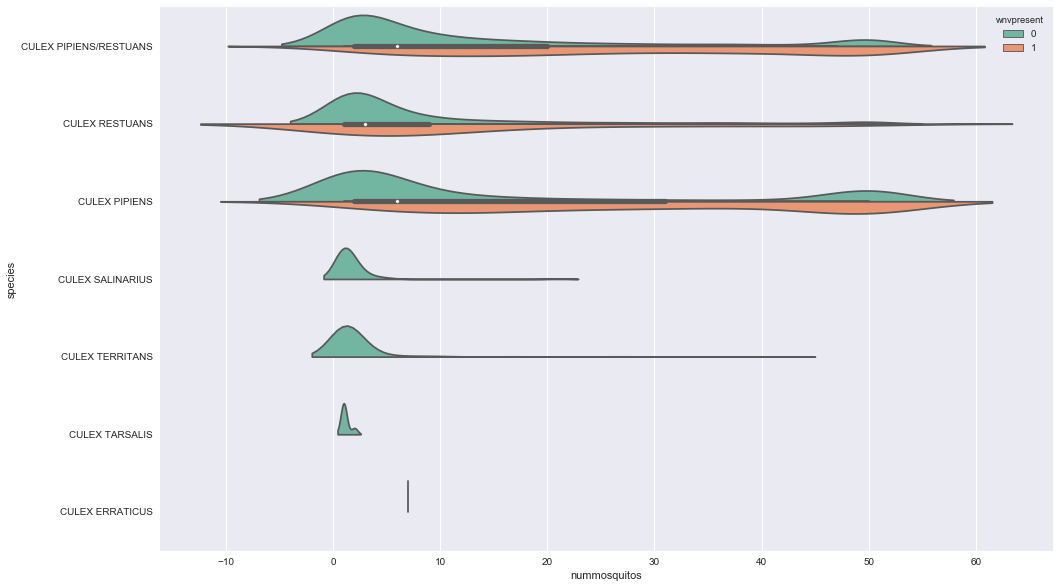

In [12]:
# WNVPresent vs nummosquitos
plt.figure(figsize=(16,10))
sns.violinplot(y="species", x="nummosquitos", hue="wnvpresent", data=train, split=True, palette="Set2");

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


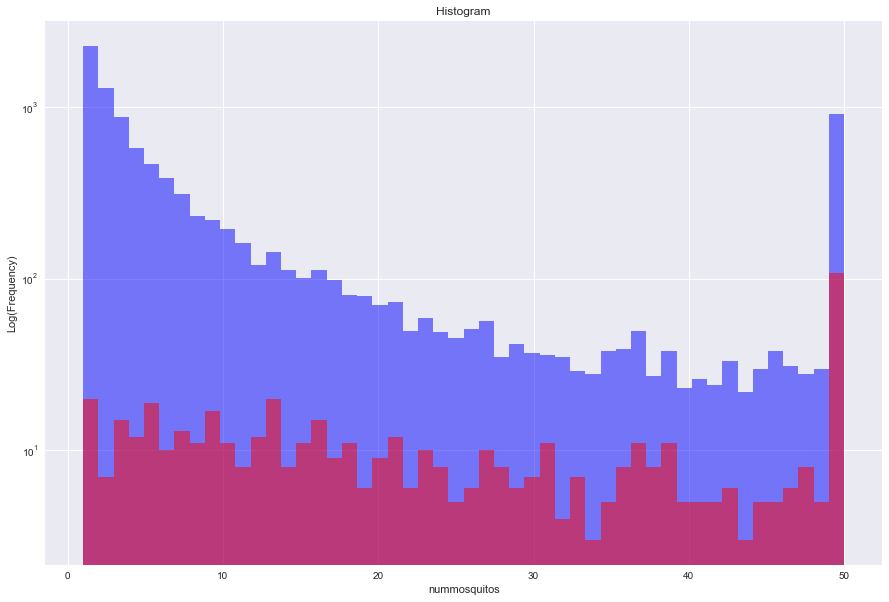

In [13]:
# Number of WNV cases present vs not present.  Used Log on the Frequency to gain better big picture insight 
col = 'nummosquitos'
var1 = train[train['wnvpresent'] == 1][col]
var2 = train[train['wnvpresent'] != 1][col]
plt.figure(figsize=(15,10))
plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
plt.title("Histogram")
plt.xlabel(col)
plt.yscale('log')
plt.ylabel("Log(Frequency)")
plt.legend;

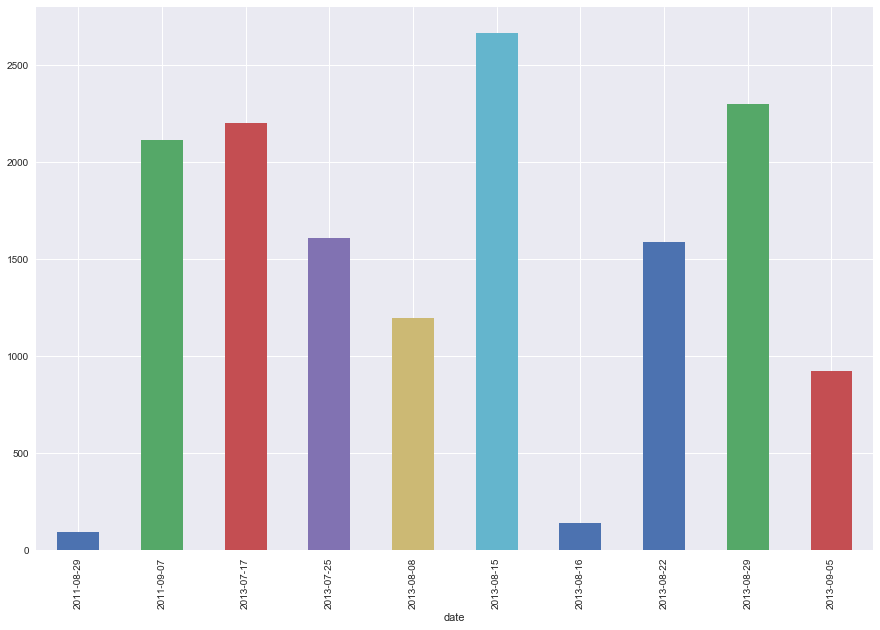

In [14]:
# Spray data
spray.groupby(['date']).size().plot(kind='bar');

<Figure size 1296x720 with 0 Axes>

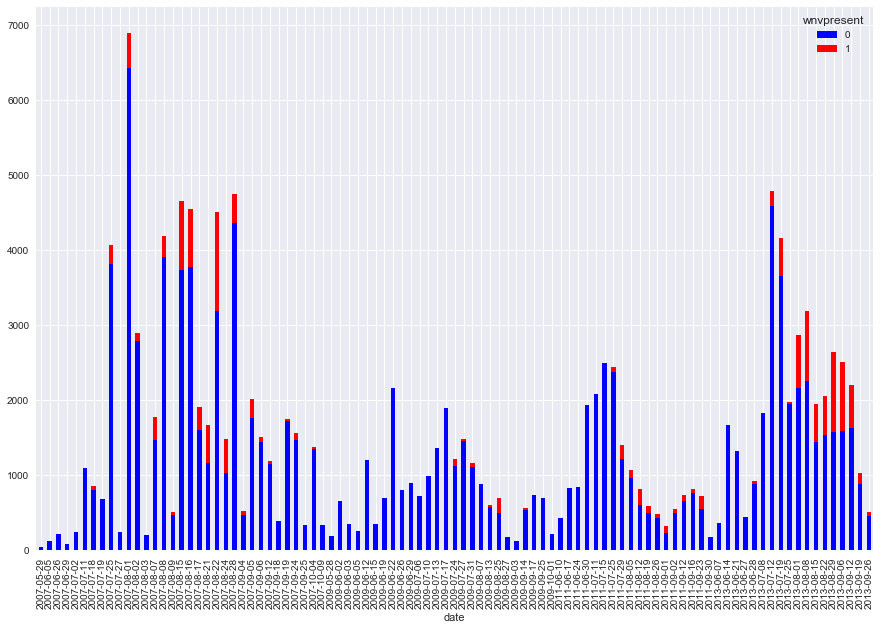

In [23]:
# WNV Present vs Num Mosquitos
plt.figure(figsize=(18,10))
train.groupby(['date', 'wnvpresent'])['nummosquitos'].sum().unstack().plot(kind='bar', 
                          stacked=True, color=['b', 'r'] );

In [26]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

### Looking At Other Data

We have access to two other data sets, spray and weather.  We want to see if we can merge and utilize this information into the training and testing data to better predict West Nile cases

In [23]:
spray.head()

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [24]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
station        2944 non-null int64
date           2944 non-null object
tmax           2944 non-null int64
tmin           2944 non-null int64
tavg           2944 non-null object
depart         2944 non-null object
dewpoint       2944 non-null int64
wetbulb        2944 non-null object
heat           2944 non-null object
cool           2944 non-null object
sunrise        2944 non-null object
sunset         2944 non-null object
codesum        2944 non-null object
depth          2944 non-null object
water1         2944 non-null object
snowfall       2944 non-null object
preciptotal    2944 non-null object
stnpressure    2944 non-null object
sealevel       2944 non-null object
resultspeed    2944 non-null float64
resultdir      2944 non-null int64
avgspeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [25]:
weather['tavg'].value_counts()

73    138
70    117
77    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
58     49
53     49
55     48
82     48
54     48
52     46
56     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
86     16
85     16
42     15
43     12
M      11
87      9
41      7
40      5
88      4
39      4
89      4
91      4
36      2
38      2
37      2
90      2
92      1
93      1
94      1
Name: tavg, dtype: int64

In [26]:
# Dropped all t-averages with missing value 'M' because there were additional missing values in each of these rows.
# Only 11 were missing.
weather = (weather[weather['tavg'] != 'M'])

In [27]:
# Look at Missing values is the depart column of weather
weather[weather['depart'] == 'M']

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5
11,2,2007-05-06,68,52,60,M,30,46,5,0,...,,M,M,M,0.00,29.62,30.28,13.8,10,14.5
13,2,2007-05-07,84,50,67,M,39,53,0,2,...,,M,M,M,0.00,29.44,30.12,8.5,17,9.9
15,2,2007-05-08,80,60,70,M,57,63,0,5,...,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
17,2,2007-05-09,76,63,70,M,60,63,0,5,...,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9
19,2,2007-05-10,83,59,71,M,52,61,0,6,...,BR HZ,M,M,M,0.00,29.26,29.91,2.0,9,3.9
21,2,2007-05-11,73,49,61,M,44,51,4,0,...,,M,M,M,0.00,29.39,30.03,11.7,36,12.8


In [28]:
# There are 0.498 missing values from weather depart column
weather['depart'].value_counts(normalize=True)

M      0.498125
 2     0.031708
-1     0.028640
-2     0.027276
 5     0.026253
 1     0.025912
 7     0.025912
 3     0.025571
 0     0.025230
-3     0.024548
 4     0.024207
 6     0.022844
 8     0.020116
-5     0.019434
-4     0.019093
-6     0.017047
 9     0.016025
10     0.015684
-8     0.014661
-7     0.010228
12     0.009547
11     0.009547
-9     0.008524
13     0.007842
-10    0.007501
14     0.007501
15     0.005114
16     0.004091
-11    0.003409
-12    0.002728
17     0.002387
-14    0.002046
18     0.002046
-13    0.001705
20     0.001364
19     0.001364
-16    0.001023
-15    0.001023
22     0.001023
-17    0.000682
21     0.000682
23     0.000341
Name: depart, dtype: float64

In [29]:
# Check for null values in Weather
weather[weather.isnull().any(axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed


In [30]:
weather.shape

(2933, 22)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
date                      10506 non-null object
address                   10506 non-null object
species                   10506 non-null object
block                     10506 non-null int64
street                    10506 non-null object
trap                      10506 non-null object
addressnumberandstreet    10506 non-null object
latitude                  10506 non-null float64
longitude                 10506 non-null float64
addressaccuracy           10506 non-null int64
nummosquitos              10506 non-null int64
wnvpresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [32]:
# Check for null values in train data
train[train.isnull().any(axis=1)]

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent


In [33]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

### Leakage

The train dataset contains some duplicate trap records as traps with mosquito counts over 50 are entered in multiple rows.  Numbers of mosquitoes does not exist in the test set so we would not expect to observe duplicate rows in that data. Therefore, we are dropping the duplicate rows below.  

In [34]:
train.drop_duplicates(subset=['trap','date','species'], inplace=True)


In [35]:
# Convert dates to datetime
spray['date']   = pd.to_datetime(spray['date'])
weather['date'] = pd.to_datetime(weather['date'])
train['date']   = pd.to_datetime(train['date'])
test['date']    = pd.to_datetime(test['date'])

In [36]:
test['date'].head()

0   2008-06-11
1   2008-06-11
2   2008-06-11
3   2008-06-11
4   2008-06-11
Name: date, dtype: datetime64[ns]

In [37]:
spray.head()

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [38]:
# Split dates into individual categories test file
test['year'] = [str(date)[0:4] for date in test.date]
test['month'] = [str(date)[5:7] for date in test.date]
test['day'] = [str(date)[8:10] for date in test.date]

In [39]:
# Split dates into individual categories train file
train['year'] = [str(date)[0:4] for date in train.date]
train['month'] = [str(date)[5:7] for date in train.date]
train['day'] = [str(date)[8:10] for date in train.date]

In [40]:
# Combine weather stations 1 and 2 based on date
weather1 = weather[weather['station'] == 1]
weather2 = weather[weather['station'] == 2]
weather1.drop(columns='station', inplace=True)
weather2.drop(columns='station', inplace=True)
weather = weather1.merge(weather2, on='date')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
# replace some missing values and T with -1 in weather
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [42]:
# Create new weather variables combining stations
weather['stnpressure_x']=weather['stnpressure_x'].astype(float)
weather['stnpressure_y']=weather['stnpressure_y'].astype(float)
weather['tavg_x']=weather['tavg_x'].astype(float)
weather['tavg_y']=weather['tavg_y'].astype(float)
weather['wetbulb_x']=weather['wetbulb_x'].astype(float)
weather['wetbulb_y']=weather['wetbulb_y'].astype(float)
weather['heat_x']=weather['heat_x'].astype(float)
weather['heat_y']=weather['heat_y'].astype(float)
weather['cool_x']=weather['cool_x'].astype(float)
weather['cool_y']=weather['cool_y'].astype(float)

weather_both = pd.DataFrame()

#creating averages of both weather stations
weather_both['date'] = weather['date']
weather_both['temp_min_both']=.5*(weather['tmin_x'] + weather['tmin_y'])
weather_both['temp_max_both']=.5*(weather['tmax_x'] + weather['tmax_y'])
weather_both['temp_avg_both']=.5*(weather['tavg_x'] + weather['tavg_y'])
weather_both['temp_dew_point_both']=.5*(weather['dewpoint_x'] + weather['dewpoint_y'])
weather_both['temp_wet_bulb_both']=.5*(weather['wetbulb_x'] + weather['wetbulb_y'])
weather_both['stnpressure_both']=.5*(weather['stnpressure_x'] + weather['stnpressure_y'])
weather_both['ht_cool_both']= weather['heat_x'] + weather['heat_y'] - weather['cool_x']- weather['cool_y']

In [43]:
# Creating aggregated columns with time lagged data for various functions.

# This allows us to see information like max temp over last 14 days or 
# avg humidity over last 3 days.

def create_agg_cols(colname, func, deltas):
    #selecting the column
    new_frame=pd.DataFrame()
    base_col=weather_both[colname]
    
    
    for delta in deltas:
        new_colname=colname+str(delta)
        new_frame[new_colname]=[0]*len(base_col)

        for i in range(delta,len(base_col)):
            relevant=base_col[i-delta: i]
            new_frame[new_colname][i]=func(relevant)

    return new_frame

In [44]:
# Create the number of days lag
deltas=[1,2,4,7,10,14]

weather_agged = weather_both

weather_agged = pd.concat([weather_agged, create_agg_cols('temp_min_both', min, deltas)], axis=1)
weather_agged = pd.concat([weather_agged, create_agg_cols('temp_max_both', max, deltas)], axis=1)
weather_agged = pd.concat([weather_agged, create_agg_cols('temp_dew_point_both', max, deltas)], axis=1)
weather_agged = pd.concat([weather_agged, create_agg_cols('temp_avg_both', np.mean, deltas)], axis=1)
weather_agged = pd.concat([weather_agged, create_agg_cols('temp_wet_bulb_both', np.mean, deltas)], axis=1)

In [45]:
# Merge weather_agged to weather dataset based on the date field
weather=weather.merge(weather_agged, on='date')

In [46]:
# Merge train and test datasets with weather dataset based on the date field
train=train.merge(weather, on='date')
test=test.merge(weather, on='date')

In [47]:
# Get rid of alpha characters in traps to create number field
train['trap']=[trap.replace("T","") for trap in train['trap']]
test['trap']=[trap.replace("T","") for trap in test['trap']]
train['trap']=[trap.replace("A","") for trap in train['trap']]
test['trap']=[trap.replace("A","") for trap in test['trap']]
train['trap']=[trap.replace("B","") for trap in train['trap']]
test['trap']=[trap.replace("B","") for trap in test['trap']]
train['trap']=[trap.replace("C","") for trap in train['trap']]
test['trap']=[trap.replace("C","") for trap in test['trap']]

In [48]:
# Change field type for trap from object to int in test and train
train['trap']=pd.to_numeric(train['trap'])
test['trap']=pd.to_numeric(test['trap'])

In [49]:
# Make dummy columns for species type in test and train
train=pd.get_dummies(train, columns=['species'], drop_first=True)
test=pd.get_dummies(test, columns=['species'], drop_first=True)

In [50]:
# Create lowercase characters and underscore species dummy columns
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]

In [51]:
train['trap'].head()

0     2
1     2
2     7
3    15
4    15
Name: trap, dtype: int64

In [52]:
train['addressnumberandstreet'].head()

0    4100  N OAK PARK AVE, Chicago, IL
1    4100  N OAK PARK AVE, Chicago, IL
2     6200  N MANDELL AVE, Chicago, IL
3      7900  W FOSTER AVE, Chicago, IL
4      7900  W FOSTER AVE, Chicago, IL
Name: addressnumberandstreet, dtype: object

In [53]:
train['address'].head()

0    4100 North Oak Park Avenue, Chicago, IL 60634,...
1    4100 North Oak Park Avenue, Chicago, IL 60634,...
2    6200 North Mandell Avenue, Chicago, IL 60646, USA
3      7900 West Foster Avenue, Chicago, IL 60656, USA
4      7900 West Foster Avenue, Chicago, IL 60656, USA
Name: address, dtype: object

In [54]:
train['wnvpresent'].head()

0    0
1    0
2    0
3    0
4    0
Name: wnvpresent, dtype: int64

In [55]:
train['trap'].value_counts()

900    154
135    147
2      147
151    143
115    143
48     139
31     139
54     136
90     135
138    129
209    128
114    126
11     125
94     123
73     123
158    121
212    120
128    119
28     113
3      113
8      113
47     110
102    109
66     108
30     108
74     107
46     106
159    104
63     103
61     101
      ... 
150     22
19      22
206     21
219     21
141     21
156     20
154     20
162     20
75      18
70      17
142     17
71      17
50      16
34      16
51      15
97      15
157     14
1       14
44      14
60      14
149     14
5       14
4       12
72      11
229      8
238      7
78       6
76       5
237      3
40       2
Name: trap, Length: 134, dtype: int64

In [56]:
test['trap'].value_counts()

90     3051
218    3051
2      2377
200    2291
54     1552
128    1534
65     1532
9      1528
94     1521
35     1520
900    1468
8       822
11      814
27      803
151     797
903     784
28      783
231     781
12      781
3       780
220     776
115     776
73      776
16      775
135     774
223     774
63      774
158     773
212     773
102     772
       ... 
25      760
107     760
88      760
215     760
44      760
150     760
86      760
149     760
85      760
43      760
91      760
84      760
155     760
219     760
19      760
146     760
234     760
18      760
92      760
156     760
81      760
17      760
157     760
232     760
40      760
143     760
79      760
15      760
206     760
154     760
Name: trap, Length: 135, dtype: int64

In [57]:
# Change types of date fields in test and train
train['year'] = train['year'].astype(float)
test['year'] = test['year'].astype(float)
train['month'] = train['month'].astype(float)
test['month'] = test['month'].astype(float)
train['day'] = train['day'].astype(float)
test['day'] = test['day'].astype(float)

### Geopy

Using Geopy, below we are using the latitude and longitude, based on the corresponding year, and creating a function that calculates the distance between positive West Nile Virus samples found in mosquitoes vs. the mosquitoes that did not test positive for the West Nile.  We repeated the process for each year in the train and test data, that will be used as features later on in our model.  The comments are the same for each function below

In [58]:
def calculate_distance(df, otherdf, year, year2):
    
    #Select out year and create tuple of lattitude and longitude
    df1 = df[df['year'] == year]
    features = ['latitude', 'longitude']
    df1 = df1[features]
    df1 = df1.apply(tuple, axis = 1)
    print(df1.shape)
    
    #Select WestNile cases from training data and create 
    #another latitude and longitude tuple
    otherdf['wnvpresent'] = otherdf['wnvpresent'].astype(float)
    westnile = otherdf[otherdf['wnvpresent']== 1]
    westnile = westnile[westnile['year'] == year2]
    westnile = westnile[features]
    westnile = westnile.apply(tuple, axis = 1)
    
    #create empty lists for distance measures
    results = []
    results_3 = []
    results_5 = []
    
    #loop through both sets of tuples and calculate distance
    for i in df1:
        dists = []   
        for j in westnile:
            
       # Use Geopy to find the difference in distances, in miles 
            dist = (geodesic(i, j).miles)
            if dist > 0:
                dists.append(dist)
   # sort and add minimum and mean minumum distances
        dists.sort()
        results.append(min(dists))
        results_3.append(sum(dists[0:3])/3)
        results_5.append(sum(dists[0:5])/5)
        
    #Merge the distance measures back to the original dataframe of 
    #year observations
    df3=pd.DataFrame(results, columns = ['distance'])
    df3['distance_3']  = results_3
    df3['distance_5']  = results_5 
    df2 = df[df['year'] == year]
    df2.reset_index(inplace = True)
    return pd.concat([ df2, df3], axis = 1)
    

In [59]:
#run function on training data
train_7 = calculate_distance(train,train,  2007, 2007)
train_9 = calculate_distance(train,train,  2009, 2009)
train_1 = calculate_distance(train,train,  2011, 2011)
train_3 = calculate_distance(train,train,  2013, 2013)

(2775,)
(1915,)
(1773,)
(2012,)


In [60]:
# Take each year of train distance data just calculated and add to new df
list = [train_7, train_9, train_1, train_3]
train_new = pd.concat(list, axis = 0, )
train_new

,index,date,address,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,temp_wet_bulb_both14,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,distance,distance_3,distance_5
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,54,0,1,0,0,0,0,1.050839,1.117797,1.176855
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,54,0,0,1,0,0,0,1.050839,1.117797,1.176855
2,2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,7,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,54,0,0,1,0,0,0,1.021493,1.021493,1.050681
3,3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,15,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,54,0,1,0,0,0,0,0.822410,0.822410,1.218078
4,4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,15,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,54,0,0,1,0,0,0,0.822410,0.822410,1.218078
5,5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,45,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,...,54,0,0,1,0,0,0,1.706440,1.706440,1.807555
6,6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,46,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,...,54,0,0,1,0,0,0,0.358443,1.191190,1.388980
7,7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,48,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,54,0,1,0,0,0,0,0.432500,0.853708,1.400547
8,8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,48,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,54,0,0,1,0,0,0,0.432500,0.853708,1.400547
9,9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,W CHICAGO,49,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,54,0,0,1,0,0,0,1.765359,1.765359,1.790267


In [61]:
#run function on testing data
test_8 = calculate_distance(test,train, 2008, 2007)
test_0 = calculate_distance(test,train, 2010, 2009)
test_2 = calculate_distance(test,train, 2012, 2011)
test_4 = calculate_distance(test,train, 2014, 2013)

(30498,)
(36557,)
(27115,)
(22123,)


In [62]:
# Take each year of test distance data just calculated and add to new df
list = [test_8, test_0, test_2, test_4]
test_new = pd.concat(list, axis = 0)
test_new.head()

,index,id,date,address,block,street,trap,addressnumberandstreet,latitude,longitude,...,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,distance,distance_3,distance_5
0,0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,1,0,0,0,0,0,1.050839,1.117797,1.176855
1,1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0,1,0,0,0,0,1.050839,1.117797,1.176855
2,2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,1,0,0,0,0,0,0,1.050839,1.117797,1.176855
3,3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0,0,1,0,0,0,1.050839,1.117797,1.176855
4,4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0,0,0,0,1,0,1.050839,1.117797,1.176855


### Seperating EDA Notebook

Due to the time intensity of the distance calculations.  We are saving the files as cvs files here and will continue the EDA and feature engineering in a separate notebook

In [64]:
# Save cleaned files
spray.to_csv('../data/sprayclean.csv', index=False)
weather.to_csv('../data/weatherclean.csv', index=False)
train_new.to_csv('../data/trainclean.csv', index=False)
test_new.to_csv('../data/testclean.csv', index=False)